In [1]:
import numpy as np
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization, PReLU, Deconvolution3D
K.set_image_data_format("channels_first")

try:
    from keras.engine import merge
except ImportError:
    from keras.layers.merge import concatenate


def unet_model_3d(input_shape, pool_size=(2, 2, 2), n_labels=1, deconvolution=False,
                  depth=4, n_base_filters=32, batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()
    num_layer = 0

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer, n_filters=n_base_filters*(2**layer_depth),
                                          batch_normalization=batch_normalization, layer_depth=num_layer)
        num_layer += 1
        layer2 = create_convolution_block(input_layer=layer1, n_filters=n_base_filters*(2**layer_depth)*2,
                                          batch_normalization=batch_normalization, layer_depth=num_layer)
        num_layer += 1
        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth-2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size, deconvolution=deconvolution,
                                            n_filters=current_layer._keras_shape[1])(current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1]._keras_shape[1], layer_depth=num_layer,
                                                 input_layer=concat, batch_normalization=batch_normalization)
        num_layer += 1
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1]._keras_shape[1], layer_depth=num_layer,
                                                 input_layer=current_layer,
                                                 batch_normalization=batch_normalization)
        num_layer += 1

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    return model

def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1), instance_normalization=False, layer_depth=None):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides, name="depth_"+str(layer_depth)+"_conv")(input_layer)
    if batch_normalization:
        layer = BatchNormalization(axis=1, name="depth_"+str(layer_depth)+"_bn")(layer)
    elif instance_normalization:
        try:
            from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
        except ImportError:
            raise ImportError("Install keras_contrib in order to use instance normalization."
                              "\nTry: pip install git+https://www.github.com/farizrahman4u/keras-contrib.git")
        layer = InstanceNormalization(axis=1, name="depth_"+str(layer_depth)+"_in")(layer)
    if activation is None:
        return Activation('relu', name="depth_"+str(layer_depth)+"_relu")(layer)
    else:
        return activation()(layer)


def compute_level_output_shape(n_filters, depth, pool_size, image_shape):
    """
    Each level has a particular output shape based on the number of filters used in that level and the depth or number 
    of max pooling operations that have been done on the data at that point.
    :param image_shape: shape of the 3d image.
    :param pool_size: the pool_size parameter used in the max pooling operation.
    :param n_filters: Number of filters used by the last node in a given level.
    :param depth: The number of levels down in the U-shaped model a given node is.
    :return: 5D vector of the shape of the output node 
    """
    output_image_shape = np.asarray(np.divide(image_shape, np.power(pool_size, depth)), dtype=np.int32).tolist()
    return tuple([None, n_filters] + output_image_shape)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2), strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:

import matplotlib.pyplot as plt
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix as CM

import os
import logging
import numpy as np
import tensorflow as tf

import keras
from keras.models import * 
from keras.optimizers import Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling3D, Dropout, BatchNormalization

In [3]:
# cretae the binary input 
def data_filter(data, label, exclu):
    idx = np.where(label!= exclu)[0]
    #print(len(idx))
    data_new = data[idx]
    label_new = label[idx]
    #print(data_new.shape)
    print(np.unique(label_new, return_counts=True))
    return data_new, label_new

# onehot encode labels for binary classifications
def onehot_bi(y):
    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    y = y.reshape(len(y), 1)
    y_encoded = onehot_encoder.fit_transform(y)
    return y_encoded

# onehot encode labels for 3-way classifications
def onehot_tri(y):
    from keras.utils import to_categorical
    return to_categorical(y)

# view the distribution of class labels of the input data
def showpercentage(array):
    pcn = array[1][0]/np.sum(array[1])
    pmci = array[1][1]/np.sum(array[1])
    pad = array[1][2]/np.sum(array[1])
    print(str(pad) + " percent of the data has AD label")
    print(str(pcn) + " percent of the data has CN label")
    print(str(pmci) + " percent of the data has MCI label")
# visualizatio of model traning and model performance 

# visualize the training and validation performance
def plot_history(data_list, label_list, title, ylabel, name):

    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title, pad = 10, fontsize='large')
    plt.xlabel('Epochs', labelpad=10)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()
#%%

# model evaluation
    
# evaluate model performance - binary classifications
def evaluate_binary(X_test, y_test, model, name):
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    test_y_prob = model.predict(X_test)
    print(test_y_prob)
    test_y_pred = np.argmax(test_y_prob, axis = 1)
    test_y_true = np.argmax(y_test, axis = 1) 
    # accuracy
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    loss, acc = model.evaluate(X_test, y_test)
    # AUC
    pos_prob = test_y_prob[:,1]
    auc_score = roc_auc_score(test_y_true, pos_prob)
    # precision, recall, specificity, and f1_score
    p = precision_score(test_y_true, test_y_pred)
    r = recall_score(test_y_true, test_y_pred)
    f1 = f1_score(test_y_true, test_y_pred)
#     sen, spe, _ = sss(test_y_true, test_y_pred, average="binary")
    print(test_y_true, test_y_pred)
    # print results
    print("Test accuracy:", acc)
    print("Test AUC is: ", auc_score)
    print("Test confusion matrix: \n", CM(test_y_true, test_y_pred))
    print("Precision: ", p)
    print("Recall: ", r)
#     print("Specificity: ", spe)
    print("f1_score: ", f1)

    # plot and save roc curve
    pos_prob = test_y_prob[:,1]
    fpr, tpr, thresholds = roc_curve(test_y_true, pos_prob)
    ns_probs = [0 for _ in range(len(test_y_prob))]
    ns_fpr, ns_tpr, _ = roc_curve(test_y_true, ns_probs)
    plt.axis([0,1,0,1]) 
    plt.plot(fpr,tpr, marker = '.', color = 'darkorange', label = 'Model AUC (area = {:.2f})'.format(auc_score)) 
    plt.plot(ns_fpr, ns_tpr, color = 'royalblue', linestyle='--')
    plt.legend()
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()
    
# evaluate model performance - 3 way classifiations
def evaluate_3way(X_test, y_test, model):
    test_y_prob = model.predict(X_test)
    test_y_pred = np.argmax(test_y_prob, axis = 1)
    test_y_true = np.argmax(y_test, axis = 1) 
    print(test_y_prob)
    # accuracy
    loss, acc = model.evaluate(X_test, y_test)
    # precision, recall, specificity, and f1_score
    p = precision_score(test_y_true, test_y_pred, average="macro")
    r = recall_score(test_y_true, test_y_pred, average="macro")
    f1 = f1_score(test_y_true, test_y_pred, average="macro")
#     sen,spe,_ = sss(test_y_true, test_y_pred, average="macro")
    print(test_y_true, test_y_pred)
    print("Test accuracy:", acc)
    print("Test confusion matrix: \n", CM(test_y_true, test_y_pred))
    print("Precision: ", p)
    print("Recall: ", r)
#     print("Specificity: ", spe)
    print("f1_score: ", f1)

In [18]:
# build the Genesis model(set %tensorflow_version 1.x for training Genesis)
def run_genesis(X_train, y_train, X_valid = None, y_valid = None, 
             final = False, out = 2,
             dr = 0.02, n_epochs = 150, batch_size = 15):
  
    input_channels, input_rows, input_cols, input_deps = 1, 64, 64, 64

    weight_dir = 'Genesis_Chest_CT.h5'

    models_genesis = unet_model_3d((input_channels, input_rows, input_cols, input_deps), batch_normalization=True)
    print("Load pre-trained Models Genesis weights from {}".format(weight_dir))
    models_genesis.load_weights(weight_dir)

    x = models_genesis.get_layer('depth_7_relu').output
    x = GlobalAveragePooling3D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dr)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dr)(x)

    output = Dense(out, activation = 'softmax')(x)

    # model optimization
    # opt = Adam(learning_rate = lr)
    model = keras.models.Model(inputs=models_genesis.input, outputs=output)
    model.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
    cb = ReduceLROnPlateau(monitor = 'val_loss', 
                         factor = 0.5, patience = 5, 
                         verbose = 1, mode = 'min')


    # model training and fine-tuning
    if not final:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            hist = model.fit(X_train, y_train,
                             batch_size = batch_size, 
                             epochs = n_epochs,
                             callbacks=[cb],
                             validation_data = (X_valid, y_valid), 
                             shuffle = True)
            evaluate_3way(X_valid, y_valid, model)
            return model, hist

    # model final training for testing (train + valid combined)
    else:
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            hist = model.fit(X_train, y_train,
                      batch_size = batch_size, 
                      epochs = n_epochs,
                      callbacks=[cb],
                      shuffle = True)


            return model, hist

In [19]:
"""  Load in the input - original data """

Xtr = np.load("preprocess/input/random_split/train_data.npy", allow_pickle = True)
ytr = np.load("preprocess/input/random_split/train_label.npy", allow_pickle = True)
print(Xtr.shape)
print(ytr.shape)

Xts = np.load("preprocess/input/random_split/test_data.npy", allow_pickle = True)
yts = np.load("preprocess/input/random_split/test_label.npy", allow_pickle = True)
print(Xts.shape)
print(yts.shape)

Xval = np.load("preprocess/input/random_split/val_data.npy", allow_pickle = True)
yval = np.load("preprocess/input/random_split/val_label.npy", allow_pickle = True)
print(Xval.shape)
print(yval.shape)

print("Train:")
showpercentage(np.unique(ytr, return_counts=True))
print()
print("Validation:")
showpercentage(np.unique(yval, return_counts=True))
print()
print("Test")
showpercentage(np.unique(yts, return_counts=True))

#%% 

(356, 64, 64, 64)
(356,)
(86, 64, 64, 64)
(86,)
(90, 64, 64, 64)
(90,)
Train:
0.2893258426966292 percent of the data has AD label
0.41853932584269665 percent of the data has CN label
0.29213483146067415 percent of the data has MCI label

Validation:
0.28888888888888886 percent of the data has AD label
0.4222222222222222 percent of the data has CN label
0.28888888888888886 percent of the data has MCI label

Test
0.29069767441860467 percent of the data has AD label
0.4186046511627907 percent of the data has CN label
0.29069767441860467 percent of the data has MCI label


(array([0, 2]), array([149, 103]))
(array([0, 2]), array([38, 26]))
(array([0, 2]), array([36, 25]))
Instructions for updating:
Colocations handled automatically by placer.
Load pre-trained Models Genesis weights from Genesis_Chest_CT.h5
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 252 samples, validate on 64 samples
Epoch 1/100
252/252 [==============================] - 19s 73ms/step - loss: 0.7836 - acc: 0.5913 - val_loss: 1.0678 - val_acc: 0.6875
Epoch 2/100
252/252 [==============================] - 8s 33ms/step - loss: 0.6650 - acc: 0.6151 - val_loss: 1.1458 - val_acc: 0.5938
Epoch 3/100
252/252 [==============================] - 8s 33ms/step - loss: 0.5616 - acc: 0.7183 - val_loss: 4.5323 - val_acc: 0.6094
Epoch 4/100
252/252 [==============================] - 8s 33ms/step - loss: 0.5080 - acc: 0.7619 - val_loss: 8.5725 - val_acc: 0.4219
Epoch 5/100
252/2

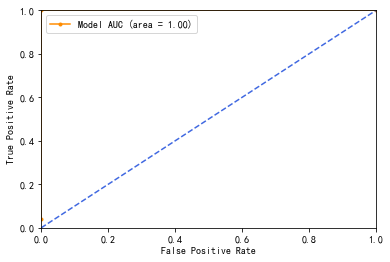

In [6]:
"""  NC vs. AD - transfer learning """

# create input for binary classification of NC vs. AD
Xtr_ncad, ytr_ncad = data_filter(Xtr, ytr, 1)
Xval_ncad, yval_ncad = data_filter(Xval, yval, 1)
Xts_ncad, yts_ncad = data_filter(Xts, yts, 1)

# reshape the input
X_train = np.transpose(Xtr_ncad.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3)) 
X_test = np.transpose(Xts_ncad.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))
X_val = np.transpose(Xval_ncad.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))

# one hot encode the target labels 
y_train = onehot_bi(ytr_ncad)
y_test = onehot_bi(yts_ncad)
y_val = onehot_bi(yval_ncad)


# model training
model, hist = run_genesis(X_train, y_train, X_val, y_val)

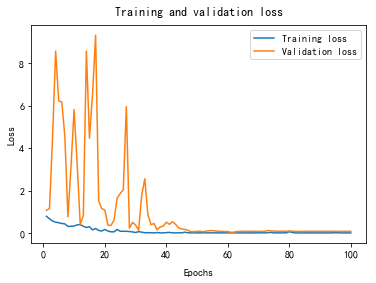

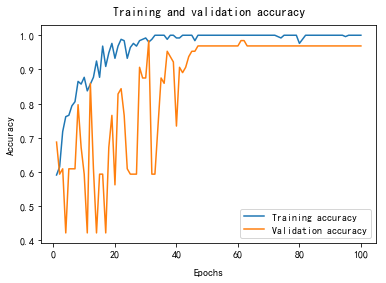

In [7]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'tf_ncad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'tf_ncad_acc')

In [9]:
"""  NC vs. MCI - transfer learning """

# create input for binary classification of NC vs. MCI
Xtr_ncmci, ytr_ncmci = data_filter(Xtr, ytr, 2)
Xval_ncmci, yval_ncmci = data_filter(Xval, yval, 2)
Xts_ncmci, yts_ncmci = data_filter(Xts, yts, 2)

# reshape the input
X_train = np.transpose(Xtr_ncmci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3)) 
X_test = np.transpose(Xts_ncmci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))
X_val = np.transpose(Xval_ncmci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))

# one hot encode the target labels 
y_train = onehot_bi(ytr_ncmci)
y_test = onehot_bi(yts_ncmci)
y_val = onehot_bi(yval_ncmci)

(array([0, 1]), array([149, 104]))
(array([0, 1]), array([38, 26]))
(array([0, 1]), array([36, 25]))


Load pre-trained Models Genesis weights from Genesis_Chest_CT.h5
Train on 253 samples, validate on 64 samples
Epoch 1/100
253/253 [==============================] - 14s 54ms/step - loss: 0.7355 - acc: 0.5415 - val_loss: 6.4282 - val_acc: 0.5938
Epoch 2/100
253/253 [==============================] - 8s 33ms/step - loss: 0.7651 - acc: 0.5099 - val_loss: 6.3435 - val_acc: 0.5938
Epoch 3/100
253/253 [==============================] - 8s 33ms/step - loss: 0.7170 - acc: 0.5415 - val_loss: 0.6632 - val_acc: 0.5938
Epoch 4/100
253/253 [==============================] - 8s 33ms/step - loss: 0.6877 - acc: 0.5494 - val_loss: 0.8673 - val_acc: 0.4063
Epoch 5/100
253/253 [==============================] - 8s 33ms/step - loss: 0.6992 - acc: 0.5336 - val_loss: 0.6850 - val_acc: 0.5938
Epoch 6/100
253/253 [==============================] - 8s 33ms/step - loss: 0.6926 - acc: 0.5731 - val_loss: 0.6754 - val_acc: 0.5938
Epoch 7/100
253/253 [==============================] - 8s 33ms/step - loss: 0.6906 - 

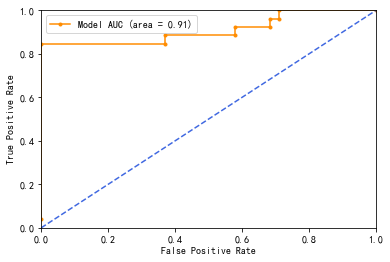

In [10]:
# model training
model, hist = run_genesis(X_train, y_train, X_val, y_val)

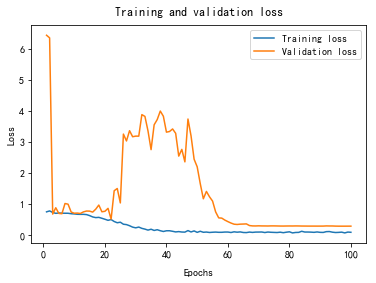

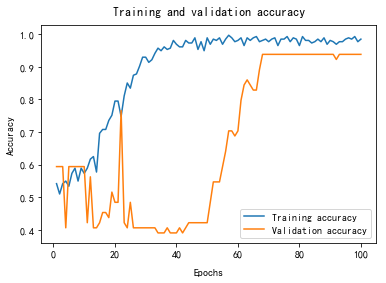

In [11]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'tf_ncmci_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'tf_ncmci_acc')

(array([1, 2]), array([104, 103]))
(array([1, 2]), array([26, 26]))
(array([1, 2]), array([25, 25]))


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f13d807dba8>>
Traceback (most recent call last):
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f13d807de10>>
Traceback (most recent call last):
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session

Load pre-trained Models Genesis weights from Genesis_Chest_CT.h5
Train on 207 samples, validate on 52 samples
Epoch 1/150
207/207 [==============================] - 12s 56ms/step - loss: 0.8090 - acc: 0.5169 - val_loss: 7.6832 - val_acc: 0.5000
Epoch 2/150
207/207 [==============================] - 7s 33ms/step - loss: 0.7139 - acc: 0.5362 - val_loss: 2.8194 - val_acc: 0.5000
Epoch 3/150
207/207 [==============================] - 7s 33ms/step - loss: 0.6732 - acc: 0.5700 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/150
207/207 [==============================] - 7s 33ms/step - loss: 0.7349 - acc: 0.4928 - val_loss: 7.9897 - val_acc: 0.5000
Epoch 5/150
207/207 [==============================] - 7s 33ms/step - loss: 0.6993 - acc: 0.4928 - val_loss: 0.9301 - val_acc: 0.5000
Epoch 6/150
207/207 [==============================] - 7s 33ms/step - loss: 0.6820 - acc: 0.5845 - val_loss: 2.6697 - val_acc: 0.5000
Epoch 7/150
207/207 [==============================] - 7s 33ms/step - loss: 0.6773 - 

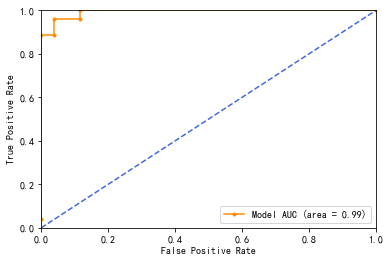

In [15]:
"""  MCI vs. AD - transfer learning """

# create input for binary classification of MCI vs. AD
Xtr_admci, ytr_admci = data_filter(Xtr, ytr, 0)
Xval_admci, yval_admci = data_filter(Xval, yval, 0)
Xts_admci, yts_admci = data_filter(Xts, yts, 0)

# reshape the input
X_train = np.transpose(Xtr_admci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3)) 
X_test = np.transpose(Xts_admci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))
X_val = np.transpose(Xval_admci.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))


# one hot encode the target labels 
y_train = onehot_bi(ytr_admci)
y_test = onehot_bi(yts_admci)
y_val = onehot_bi(yval_admci)

# model training
model, hist = run_genesis(X_train, y_train, X_val, y_val)

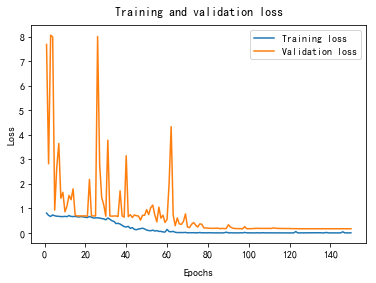

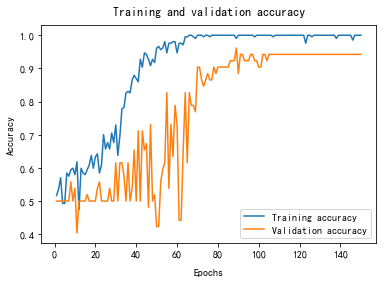

In [16]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'tf_mciad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'tf_mciad_acc')

In [20]:
"""  NC vs. MCI vs. AD - transfer learning """

# reshape the input for 3-way classification of NC vs. MCI vs. AD
X_train = np.transpose(Xtr.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3)) 
X_test = np.transpose(Xts.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))
X_val = np.transpose(Xval.reshape(-1,64,64,64,1), (0, 4, 1, 2, 3))

# one hot encode the target labels 
y_train = onehot_tri(ytr)
y_test = onehot_tri(yts)
y_val = onehot_tri(yval)


# model training
model, hist = run_genesis(X_train, y_train, X_val, y_val, out = 3)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f139e078d30>>
Traceback (most recent call last):
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f139ca60da0>>
Traceback (most recent call last):
  File "/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session

Load pre-trained Models Genesis weights from Genesis_Chest_CT.h5
Train on 356 samples, validate on 90 samples
Epoch 1/150
356/356 [==============================] - 18s 50ms/step - loss: 1.2129 - acc: 0.3680 - val_loss: 5.5414 - val_acc: 0.4222
Epoch 2/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0782 - acc: 0.4410 - val_loss: 1.1851 - val_acc: 0.4444
Epoch 3/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0554 - acc: 0.4242 - val_loss: 3.7659 - val_acc: 0.4222
Epoch 4/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0103 - acc: 0.4888 - val_loss: 1.6051 - val_acc: 0.4222
Epoch 5/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0396 - acc: 0.4635 - val_loss: 1.1098 - val_acc: 0.2333
Epoch 6/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0405 - acc: 0.4466 - val_loss: 1.2229 - val_acc: 0.4444
Epoch 7/150
356/356 [==============================] - 12s 33ms/step - loss: 1.0

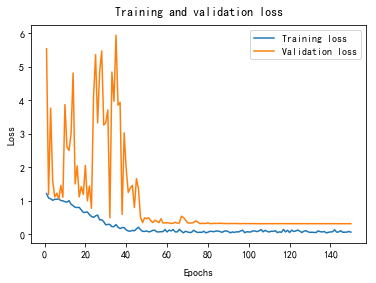

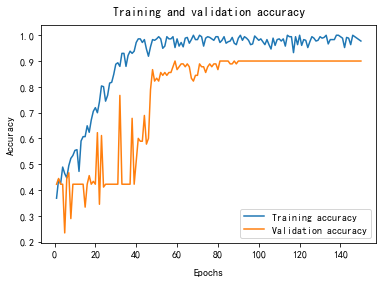

In [21]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'tf_ncmciad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'tf_ncmciad_acc')